In [46]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import os, re
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from string import punctuation
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten, LSTM, Bidirectional, GRU
import gensim

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/kaggle/input/poem-classification-nlp/Poem_classification - test_data.csv
/kaggle/input/poem-classification-nlp/Poem_classification - train_data.csv


In [2]:
poem = pd.read_csv('/kaggle/input/poem-classification-nlp/Poem_classification - train_data.csv')
print(poem.shape)
poem = poem.rename(columns=lambda x: x.lower())
poem.head()

(841, 2)


,genre,poem
0,Music,NaN
1,Music,In the thick brushthey spend the...
2,Music,Storms are generous. ...
3,Music,—After Ana Mendieta Did you carry around the ...
4,Music,for Aja Sherrard at 20The portent may itself ...


<Axes: xlabel='genre', ylabel='count'>

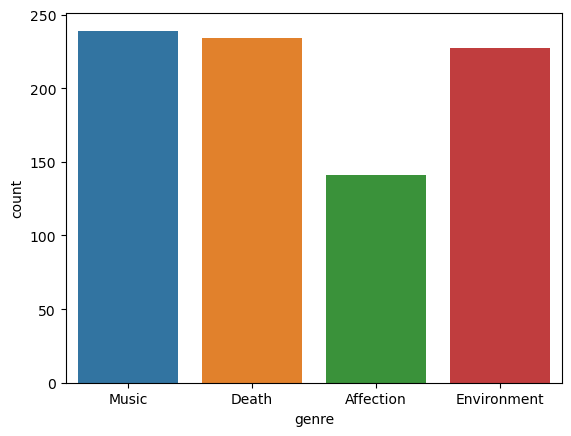

In [3]:
# poem.genre.value_counts()
sns.countplot(x=poem.genre)
# plt.plot()

In [4]:
print(f"NA count: {poem.poem.isna().sum()}")
poem = poem.dropna()
print(f'poem shape: {poem.shape}')

NA count: 4
poem shape: (837, 2)


# Дополнительная предобработка текста

Определить характерные слова для каждой группы

In [5]:
music = set(' '.join(poem.loc[poem.genre=='Music', 'poem']).split())
death = set(' '.join(poem.loc[poem.genre=='Death', 'poem']).split())
affection = set(' '.join(poem.loc[poem.genre=='Affection', 'poem']).split())
env = set(' '.join(poem.loc[poem.genre=='Environment', 'poem']).split())

In [6]:
print(f'music len: {len(music)}')
print(f'death len: {len(death)}')
print(f'affection len: {len(affection)}')
print(f'environment len: {len(env)}')

music len: 4586
death len: 4488
affection len: 2940
environment len: 4406


In [7]:
music_uniq = music - death - affection - env
death_uniq = death - music - affection - env
affection_uniq = affection - music - death - env
env_uniq = env - music - death - affection

print(f'music unique len: {len(music_uniq)}')
print(f'death unique len: {len(death_uniq)}')
print(f'affection unique len: {len(affection_uniq)}')
print(f'environment unique len: {len(env_uniq)}')

music unique len: 2611
death unique len: 2508
affection unique len: 1436
environment unique len: 2606


In [94]:
_X = poem[['poem', 'genre']]
_X.poem = _X.poem.apply(lambda x: x.lower())
_X.poem = _X.poem.apply(lambda x: re.sub(r'[^\w+\s]', '', x))
_X.head()

def check_words(text, variant):
    uniq_w = []
    for i in text.split():
        if i in variant: uniq_w.append(i)
    return ' '.join(uniq_w)

In [95]:
_X.loc[_X.genre == 'Music', 'poem'] = _X.loc[_X.genre == 'Music', 'poem'].apply(lambda x: check_words(x, music_uniq))
_X.loc[_X.genre == 'Death', 'poem'] = _X.loc[_X.genre == 'Death', 'poem'].apply(lambda x: check_words(x, death_uniq))
_X.loc[_X.genre == 'Affection', 'poem'] = _X.loc[_X.genre == 'Affection', 'poem'].apply(lambda x: check_words(x, affection_uniq))
_X.loc[_X.genre == 'Environment', 'poem'] = _X.loc[_X.genre == 'Environment', 'poem'].apply(lambda x: check_words(x, env_uniq))

_X

,poem,genre
1,brushthey hottest soaking hoovesin hoardson be...,Music
2,easy surrender sitting,Music
3,wingspan,Music
4,portent scores adults carrions distressof loyalty,Music
5,1980,Music
...,...,...
836,fragmentary presents sheets savants include,Environment
837,stem shadowed torque,Environment
838,brawny oarsman sunburnt cheek soothes quickly,Environment
839,fetch burying barren ere,Environment


# Стоп-слова

In [21]:
stop_words = set(stopwords.words('english'))
stop_words.update(["i'm", "you're", "we're", "they're", "he's", "she's", "it's", "us", "shall", "might", "may", "must", "would", "could", "ought", "many", "much", "more"])
stop_words.update(["im", "youre", "were", "theyre", "hes", "shes"])

In [ ]:
poem.poem = poem.poem.apply(lambda x: x.lower())

In [22]:
def remove_stopwords(text):
    cleaned = [i.strip() for i in text.split() if i not in stop_words]
    return ' '.join(cleaned)
# poem.poem = poem.poem.apply(lambda x: re.sub(r'like|this one', '', x))
# poem.poem = poem.poem.apply(lambda x: remove_stopwords(x))
# print(poem.head())

In [ ]:
poem.poem = poem.poem.apply(lambda x: re.sub(r'[^\w+\s]', '', x))
print(poem.head())
poem.poem = poem.poem.apply(lambda x: remove_stopwords(x))

In [ ]:
Counter(' '.join(poem.loc[poem.genre =='Music'].poem).split()).most_common(10)

In [ ]:
Counter(' '.join(poem.loc[poem.genre =='Death'].poem).split()).most_common(10)

In [ ]:
poem.loc[poem.genre == 'Death']

In [ ]:
pd.get_dummies(poem.genre)

In [ ]:
target = pd.get_dummies(poem.genre)
poem.head()

In [ ]:
target.head()

In [ ]:
round(poem.poem.apply(lambda x: len(x.split())).mean())

# Test val

In [96]:
poem_test = pd.read_csv('/kaggle/input/poem-classification-nlp/Poem_classification - test_data.csv')
print(poem_test.shape)
poem_test = poem_test.rename(columns=lambda x: x.lower())
poem_test.head()

(150, 2)


,genre,poem
0,Music,A woman walks by the bench I’m sitting onwith ...
1,Music,"Because I am a boy, the untouchability of beau..."
2,Music,"Because today we did not leave this world,We n..."
3,Music,"Big Bend has been here, been here. Shouldn’t i..."
4,Music,"I put shells there, along the lip of the road...."


<Axes: xlabel='genre', ylabel='count'>

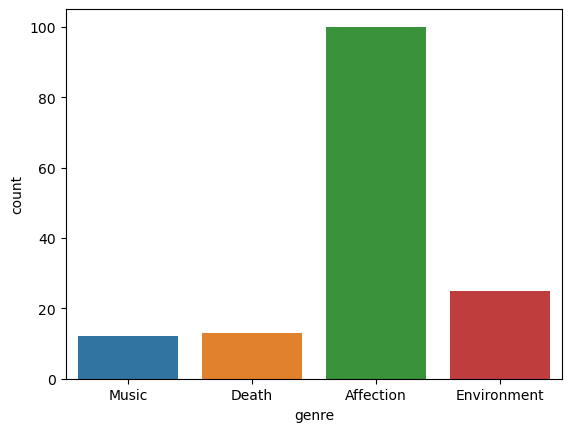

In [53]:
sns.countplot(x=poem_test.genre)

In [97]:
print(f"NA count: {poem_test.poem.isna().sum()}")
poem_test = poem_test.dropna()
print(f'poem shape: {poem_test.shape}')

NA count: 0
poem shape: (150, 2)


In [98]:
poem_test.poem = poem_test.poem.apply(lambda x: x.lower())
poem_test.poem = poem_test.poem.apply(lambda x: re.sub(r'like|this one', '', x))
poem_test.poem = poem_test.poem.apply(lambda x: remove_stopwords(x))
poem_test.poem = poem_test.poem.apply(lambda x: re.sub(r'[^\w+\s]', '', x))
poem_test.poem = poem_test.poem.apply(lambda x: remove_stopwords(x))

In [ ]:
# target_test = pd.get_dummies(poem_test.genre)
# target_test.head()

In [99]:
poem_test.head()

,genre,poem
0,Music,woman walks bench sitting onwith dog looks par...
1,Music,boy untouchability beautyis subject already bo...
2,Music,today leave worldwe embody prominence within i...
3,Music,big bend shouldnt saycall mountains wall river...
4,Music,put shells along lip roadbivalves last summers...


# Tokenization

In [75]:
uniq_words = set()
for i in _X.poem:
    uniq_words.update(i.split())
print(f'Unique words: {len(uniq_words)}')

Unique words: 6811


In [101]:
meanlen = round(poem.poem.apply(lambda x: len(x.split())).mean())
max_words = round(len(uniq_words),-3)
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(_X.poem)

x_train = np.array(tokenizer.texts_to_sequences(_X.poem))
x_train = sequence.data_utils.pad_sequences(x_train, maxlen=meanlen)
# y_train = np.array(target)
y_train = pd.get_dummies(_X.genre)

# x_val, y_val = train_test_split(x_train, y_train, test_size = 0.25, stratify = y_train, random_state = 12)

x_test = np.array(tokenizer.texts_to_sequences(poem_test.poem))
x_test = sequence.data_utils.pad_sequences(x_test, maxlen=maxlen)
# y_test = np.array(target_test)

/tmp/ipykernel_32/446663572.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train = np.array(tokenizer.texts_to_sequences(_X.poem))
/tmp/ipykernel_32/446663572.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test = np.array(tokenizer.texts_to_sequences(poem_test.poem))


In [102]:
print('maxlen: ', meanlen)
print('max_words: ', max_words)

maxlen:  47
max_words:  7000


In [103]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.3, stratify = y_train, random_state = 12)

In [86]:
print(f'x_train shape: {x_train.shape}')
print(f'x_val shape: {x_val.shape}')
print(f'x_test shape: {x_test.shape}')

x_train shape: (438, 47)
x_val shape: (189, 47)
x_test shape: (150, 47)


# Base model

In [110]:
model1 = Sequential(layers=[
    Embedding(max_words, 8, input_length=maxlen),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(4, activation='sigmoid')
])
model1.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['acc'])
model1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 47, 8)             56000     
                                                                 
 flatten_3 (Flatten)         (None, 376)               0         
                                                                 
 dense_15 (Dense)            (None, 32)                12064     
                                                                 
 dense_16 (Dense)            (None, 16)                528       
                                                                 
 dense_17 (Dense)            (None, 4)                 68        
                                                                 
Total params: 68,660
Trainable params: 68,660
Non-trainable params: 0
_________________________________________________________________


In [111]:
model1.fit(x_train, y_train, epochs=500, batch_size=32, validation_data=(x_val, y_val), verbose=False)

In [112]:
predict1 = (model1.predict(x_test)>0.5).astype('int32')
res1 = pd.DataFrame(data=predict1, columns=pd.get_dummies(_X.genre).columns).idxmax(axis=1)
print(classification_report(poem_test.genre, res1))

5/5 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

   Affection       0.71      0.67      0.69       100
       Death       0.00      0.00      0.00        13
 Environment       0.05      0.04      0.05        25
       Music       0.10      0.17      0.12        12

    accuracy                           0.47       150
   macro avg       0.21      0.22      0.21       150
weighted avg       0.49      0.47      0.48       150



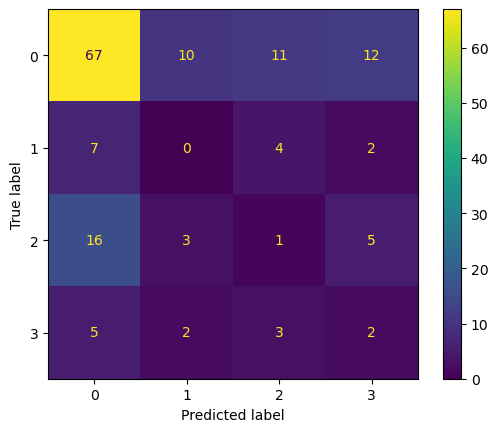

In [113]:
# уникальные слова, train выборка не одного регистра
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(poem_test.genre, res1)).plot()

# LSTM и GRU

In [36]:
model2 = Sequential(layers=[
    Embedding(max_words, 8, input_length=maxlen),
    LSTM(units=64, dropout=0.15, recurrent_dropout=0.2, return_sequences=True),
    GRU(units=32, dropout=0.1, recurrent_dropout=0.05),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(4, activation='sigmoid')
])
model2.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['acc'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 47, 8)             72000     
                                                                 
 lstm (LSTM)                 (None, 47, 64)            18688     
                                                                 
 gru (GRU)                   (None, 32)                9408      
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 4)                 68        
                                                                 
Total params: 101,748
Trainable params: 101,748
Non-tr

In [107]:
model2.fit(x_train, y_train, epochs=500, batch_size=32, validation_data=(x_val, y_val), verbose=False)

In [108]:
predict2 = (model2.predict(x_test)>0.5).astype('int32')
res2 = pd.DataFrame(data=predict2, columns=pd.get_dummies(_X.genre).columns).idxmax(axis=1)
print(classification_report(poem_test.genre, res2))

5/5 [==============================] - 0s 16ms/step
              precision    recall  f1-score   support

   Affection       0.70      0.26      0.38       100
       Death       0.00      0.00      0.00        13
 Environment       0.10      0.08      0.09        25
       Music       0.05      0.25      0.09        12

    accuracy                           0.21       150
   macro avg       0.21      0.15      0.14       150
weighted avg       0.49      0.21      0.27       150



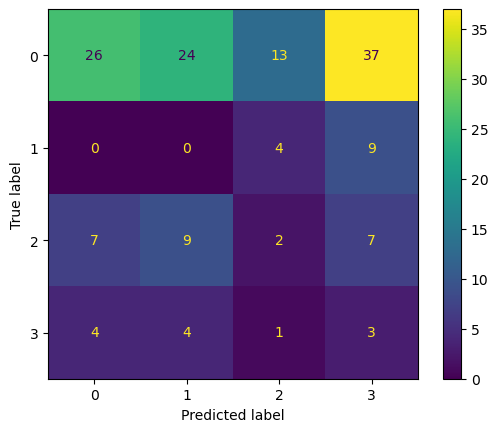

In [109]:
# уникальные слова, train выборка не одного регистра
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(poem_test.genre, res2)).plot()

# Bidirectional

In [39]:
model3 = Sequential(layers=[
    Embedding(max_words, 8, input_length=maxlen),
    Bidirectional(LSTM(units=64, dropout=0.15, recurrent_dropout=0.2, return_sequences=True)),
    Bidirectional(GRU(units=32, dropout=0.1, recurrent_dropout=0.05)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(4, activation='sigmoid')
])
model3.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['acc'])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 47, 8)             72000     
                                                                 
 bidirectional (Bidirectiona  (None, 47, 128)          37376     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               31104     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dense_8 (Dense)             (None, 4)                

In [115]:
model3.fit(x_train, y_train, epochs=500, batch_size=32, validation_data=(x_val, y_val), verbose=False)
%%time

UsageError: Line magic function `%%time` not found.


In [116]:
predict3 = (model3.predict(x_test)>0.5).astype('int32')
res3 = pd.DataFrame(data=predict3, columns=pd.get_dummies(_X.genre).columns).idxmax(axis=1)
print(classification_report(poem_test.genre, res3))

5/5 [==============================] - 0s 28ms/step
              precision    recall  f1-score   support

   Affection       0.66      0.25      0.36       100
       Death       0.05      0.15      0.07        13
 Environment       0.04      0.04      0.04        25
       Music       0.02      0.08      0.04        12

    accuracy                           0.19       150
   macro avg       0.19      0.13      0.13       150
weighted avg       0.45      0.19      0.26       150



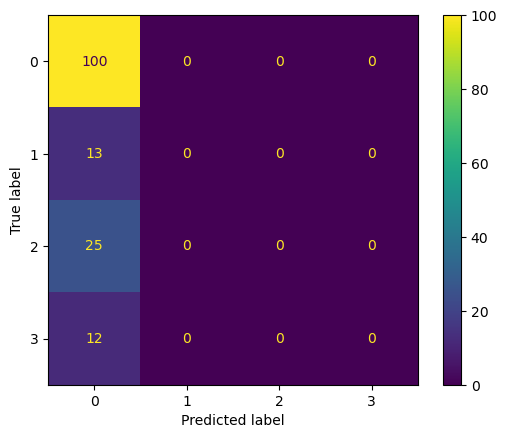

In [70]:
# уникальные слова в train, train выборка не одного регистра
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(poem_test.genre, res3)).plot()

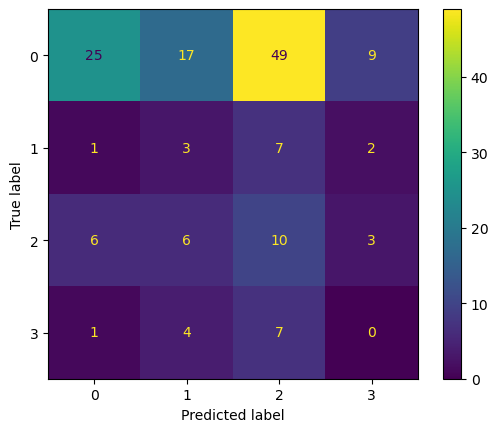

In [73]:
# уникальные слова в train, train выборка  одного регистра
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(poem_test.genre, res3)).plot()